# NLP - Assignment 2

## Imports

In [34]:
import pandas as pd
from collections import Counter
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from FuzzyTM import FLSA_W
from gensim.models import CoherenceModel, Phrases
import matplotlib.pyplot as plt
import gensim
from gensim import corpora
from wordcloud import WordCloud
import nbformat

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\solqu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\solqu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\solqu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocess Data

In [11]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv(path)
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [12]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]

In [13]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [14]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the default stop words
default_stop_words = set(stopwords.words('english'))

def preprocess_text(text,
                    remove_punctuation=True,
                    remove_stopwords=True,
                    lemmatize=False,
                    remove_short_words=False,
                    remove_numbers=True,
                    min_word_length=2,
                    remove_words=None,  # specific words to remove
                    meaningful_words=None  # meaningful words to keep
                   ):
    """
    Advanced preprocessing function that applies different levels of text processing.

    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.
    - remove_words: A list of specific words to remove.
    - meaningful_words: A list of meaningful words to exclude from stop words.

    Returns:
    - Preprocessed text as tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Remove stopwords, excluding meaningful words
    if remove_stopwords:
        stop_words = default_stop_words
        if meaningful_words:
            stop_words = stop_words - set(meaningful_words)  # Exclude meaningful words from stop words
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]

    # Calculate global word frequencies
    global_word_frequencies = Counter(tokens)

    # Remove specific words
    if remove_words:
        tokens = [token for token in tokens if token not in remove_words]

    return tokens

In [15]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.

    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').

    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """

    # Make a copy of the dataset for each version to avoid overwriting the original content
    dataset_copy = nvidia_dataset.copy()

    if version == 'v1':
        # Basic tokenization and lowercasing
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x,
            remove_punctuation=False,
            remove_stopwords=False,
            lemmatize=False,
            remove_numbers=False,
            remove_short_words=False
        ))

    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x,
            remove_punctuation=True,
            remove_stopwords=True,
            lemmatize=False,
            remove_numbers=True,
            remove_short_words=False,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down']
        ))

    elif version == 'v3':
        # Full preprocessing with lemmatization, number removal, and short words removal
        dataset_copy['preprocessed_content'] = dataset_copy['content'].apply(lambda x: preprocess_text(
            x,
            remove_punctuation=True,
            remove_stopwords=True,
            lemmatize=True,
            remove_numbers=True,
            remove_short_words=True,
            min_word_length=2,
            remove_words=['nvidia', 'nvda'],
            meaningful_words=['up', 'down', 'through', 'during', 'before', 'after', 'above', 'below']
        ))

    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3'")

    # Return a separate DataFrame for each version with preprocessed content
    return dataset_copy


In [16]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with lemmatizer

train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,A Central Bank War Just Started And Its Good F...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[a, central, bank, war, just, started, and, it..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch Nivida Could Be Falling 6 S...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[6, stocks, to, watch, nivida, could, be, fall..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Stocks Dow Drops Nearly 400 Points as Apple ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[stocks, dow, drops, nearly, 400, points, as, ..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,The Zacks Analyst Blog Highlights Advanced Mi...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[the, zacks, analyst, blog, highlights, advanc..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,The Best Of CES 2020 Revised With 4 500 comp...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[the, best, of, ces, 2020, revised, with, 4, 5..."


In [12]:
unique_words_v1 = set([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
unique_words_v2 = set([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
unique_words_v3 = set([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

print("Unique words in v1:", len(unique_words_v1))
print("Unique words in v2:", len(unique_words_v2))
print("Unique words in v3:", len(unique_words_v3))

Unique words in v1: 36322
Unique words in v2: 32137
Unique words in v3: 29056


In [13]:
# Flatten lists and count word frequencies
freq_v1 = Counter([word for sublist in train_data_v1['preprocessed_content'] for word in sublist])
freq_v2 = Counter([word for sublist in train_data_v2['preprocessed_content'] for word in sublist])
freq_v3 = Counter([word for sublist in train_data_v3['preprocessed_content'] for word in sublist])

# Print the most common words side by side for easier comparison
def print_side_by_side(freq_v1, freq_v2, freq_v3, top_n=10):
    print(f"{'Rank':<5} {'v1':<20} {'Count':<10} {'v2':<20} {'Count':<10} {'v3':<20} {'Count':<10}")
    print("="*100)
    for i, ((word1, count1), (word2, count2), (word3, count3)) in enumerate(zip(freq_v1.most_common(top_n), freq_v2.most_common(top_n), freq_v3.most_common(top_n)), 1):
        print(f"{i:<5} {word1:<20} {count1:<10} {word2:<20} {count2:<10} {word3:<20} {count3:<10}")

print_side_by_side(freq_v1, freq_v2, freq_v3)

Rank  v1                   Count      v2                   Count      v3                   Count     
1     the                  126904                          144555     stock                16293     
2     to                   61701      nasdaq               14831      year                 16074     
3     and                  55488      year                 13876      company              15430     
4     of                   54474      zacks                11672      nasdaq               14831     
5     in                   46306      company              11343      zacks                11672     
6     a                    44793      earnings             10457      market               10686     
7     s                    32960      stocks               8935       earnings             10457     
8     is                   26139      market               8385       quarter              8718      
9     for                  24701      quarter              7809       share       

In [14]:
# Flatten the list of lists to get a single list of words
all_tokens_v3 = [word for sublist in train_data_v3['preprocessed_content'] for word in sublist]

# Get the 50 most common words
common_words_v3 = Counter(all_tokens_v3).most_common(50)

# Print the most common 50 words and their respective frequencies
print('Most common 50 words and respective frequencies:\n')
for i, (word, freq) in enumerate(common_words_v3, 1):
    print(f'{i:<2}- {word:<15} {freq}')

Most common 50 words and respective frequencies:

1 - stock           16293
2 - year            16074
3 - company         15430
4 - nasdaq          14831
5 - zacks           11672
6 - market          10686
7 - earnings        10457
8 - quarter         8718
9 - share           8282
10- growth          7409
11- revenue         7334
12- up              6939
13- billion         6322
14- also            6220
15- nyse            6159
16- technology      5586
17- estimate        5547
18- new             5150
19- investor        5036
20- million         4806
21- rank            4789
22- last            4759
23- week            4594
24- inc             4564
25- expected        4280
26- after           4269
27- day             4199
28- report          4161
29- price           4134
30- buy             4067
31- trade           4037
32- investment      3904
33- one             3874
34- time            3862
35- data            3856
36- high            3855
37- strong          3688
38- per           

In [15]:
print(f"Number of unique words: {len(set(all_tokens_v3)):,}")
print(f"Lexical richness: {len(set(all_tokens_v3))/len(all_tokens_v3):.4f}")

Number of unique words: 29,056
Lexical richness: 0.0210


## Helper functions

In [17]:
def remove_top_bottom_words(preprocessed_content, top_percent=10, bottom_percent=10, words_to_exclude=None):
    """
    Remove top-n% and bottom-n% words based on frequency and exclude specified words.

    Parameters:
    - preprocessed_content: list of lists, the preprocessed content
    - top_percent: int, the top n% of words to remove
    - bottom_percent: int, the bottom n% of words to remove
    - words_to_exclude: set, the words to exclude

    Returns:
    - list of lists, the content with specified words removed
    """
    # Flatten the list of lists to get a single list of words
    all_words = [word for sublist in preprocessed_content for word in sublist]

    # Get the word frequencies
    word_freq = Counter(all_words)

    # Calculate the number of words to remove
    total_words = len(word_freq)
    top_n = int(total_words * top_percent / 100)
    bottom_n = int(total_words * bottom_percent / 100)

    # Get the top-n% and bottom-n% words
    top_words = set([word for word, freq in word_freq.most_common(top_n)])
    bottom_words = set([word for word, freq in word_freq.most_common()[:-bottom_n-1:-1]])

    # Combine the words to exclude
    words_to_remove = top_words | bottom_words
    if words_to_exclude:
        words_to_remove |= words_to_exclude

    # Remove the specified words from the content
    filtered_content = [[word for word in sublist if word not in words_to_remove] for sublist in preprocessed_content]

    return filtered_content

In [18]:
def print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=20):
    """
    Print the most common bigrams in the tokenized text data.

    Parameters:
    - bigrams: the bigrams created (if any)
    - train_data_list_tokens: list of list of str, the tokenized text data
    - top_n: int, the number of most common bigrams to print
    """
    if bigrams is None:
        print("No bigrams were created.")
        return

    # Transform the tokenized text data to include bigrams
    bigram_mod = bigrams[train_data_list_tokens]

    # Flatten the list of lists to get a single list of tokens
    all_tokens = [token for doc in bigram_mod for token in doc]

    # Count the frequency of each token
    token_freq = Counter(all_tokens)

    # Extract and count the bigrams
    bigram_freq = Counter({token: freq for token, freq in token_freq.items() if '_' in token})

    # Print the most common bigrams
    print(f'Top {top_n} most common bigrams and respective frequencies:\n')
    for i, (bigram, freq) in enumerate(bigram_freq.most_common(top_n), 1):
        print(f'{i:<2}- {bigram:<30} {freq}')

In [19]:
# Function to plot Topic-Words Importance as a Word Cloud
def plot_topic_words_importance(topic_tuples, model):
    for topic_idx, topic_str in topic_tuples:
        # Parse the topic string to extract word-probability pairs
        word_freq = {}
        for item in topic_str.split(' + '):
            prob, word = item.split('*')
            word = word.strip('"')
            prob = float(prob)
            word_freq[word] = prob

        # # Normalize the probabilities to sum to 1
        # total_prob = sum(word_freq.values())
        # for word in word_freq:
        #     word_freq[word] /= total_prob

        # Scale probabilities to enhance visualization
        scaling_factor = 1000
        for word in word_freq:
            word_freq[word] *= scaling_factor

        print(f"Topic {topic_idx}: {word_freq}")

        # Generate a word cloud from the word frequencies
        wordcloud = WordCloud(width=800,
                              height=400,
                              background_color='white',
                              relative_scaling=0 # make font sizes directly proportional to frequencies without additional scaling
                              ).generate_from_frequencies(word_freq)
        # Plot the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'{model} Topic {topic_idx + 1} - Words Importance')
        plt.show()

### LDA

In [20]:
def lda_print_evaluation_metrics(lda_model, train_data_list, dictionary):
    """
    Print the evaluation metrics for a trained LDA model, including coherence score.

    Parameters:
    - lda_model: Trained LDA model.
    - train_data_list: List of tokenized documents (for coherence calculation).
    - dictionary: Gensim dictionary.
    """
    # Show topics with word probabilities
    print("\n\nLDA Topics with Word Probabilities:\n")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx + 1}: {topic}")

    # Vocabulary size
    print(f"\nVocabulary size: {len(dictionary):,}")

    # Coherence Score Calculation
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=train_data_list,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    print("\nCoherence Score:", round(coherence_score, 4))


### FLSA-W

In [21]:
def compute_coherence_flsa_w(train_data, max_topics=10, num_words_list=[5, 7, 10]):
    """
    Compute coherence scores for FLSA-W model with varying number of topics and words per topic.

    Parameters:
        - train_data: list of tokenized documents (preprocessed content).
        - max_topics: int, the maximum number of topics to test.
        - num_words_list: list of int, different numbers of words per topic to test.
        - display: bool, if True, will print the results in a structured format per num_words.

    Returns:
        - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """

    tokenized_data = [tokens for tokens in train_data['preprocessed_content']]

    results = []

    # Loop through each number of words per topic first
    for num_words in num_words_list:
        print(f"\n=== Results for {num_words} words per topic ===")

        # Loop through each number of topics for the current number of words
        for num_topics in range(2, max_topics + 1):
            # Train FLSA-W model with the current num_words and num_topics
            flsa_w_model = FLSA_W(
                input_file=tokenized_data,
                num_topics=num_topics,
                num_words=num_words
            )

            # Train the FLSA-W model
            flsa_w_model.get_matrices()

            # Get the coherence score for the current model
            coherence_score = flsa_w_model.get_coherence_score()

            # Store the results as a tuple (num_words, num_topics, coherence_score)
            results.append((num_words, num_topics, coherence_score))

            print(f"Number of topics: {num_topics}, Coherence score: {coherence_score:.4f}")

    return results


In [22]:
def plot_elbow_curve(results):
    """
    Create elbow plots for coherence scores vs. number of topics for different num_words.

    Parameters:
    - results: list of tuples, each containing (num_words, num_topics, coherence_score).
    """
    # Organize results by num_words
    num_words_dict = {}
    for num_words, num_topics, coherence_score in results:  # Corrected tuple unpacking order
        if num_words not in num_words_dict:
            num_words_dict[num_words] = {'num_topics': [], 'coherence_scores': []}
        num_words_dict[num_words]['num_topics'].append(num_topics)
        num_words_dict[num_words]['coherence_scores'].append(coherence_score)

    # Plot each num_words line
    plt.figure(figsize=(10, 6))
    for num_words, data in num_words_dict.items():
        plt.plot(data['num_topics'], data['coherence_scores'], marker='o', label=f'Num words: {num_words}')

    # Add plot labels and title
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score for Different Number of Words per Topic')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend(title='Words per Topic')
    plt.grid(True)
    plt.show()

In [23]:
def flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics):
    """
    Print the evaluation metrics for the trained FLSA-W model.

    Parameters:
    - flsa_w_model: the trained FLSA-W model
    - flsa_w_topics: the topics generated by the FLSA-W model
    """
    # Show the topics generated with word probabilities
    print("\n\nFLSA-W Topics with Word Probabilities:\n")
    for topic in flsa_w_model.show_topics():
        print(topic)

    # Show the topics generated
    print("\n\nFLSA-W Topics:\n")
    for i, topic in enumerate(flsa_w_topics):
        print(f"Topic {i + 1}: {', '.join(topic)}")

    print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

    # Show topic quality scores
    print("\nCoherence Score:", round(flsa_w_model.get_coherence_score(), 4))
    print("Diversity Score:", round(flsa_w_model.get_diversity_score(), 4))
    print("Interpretability Score:", round(flsa_w_model.get_interpretability_score(), 4))

### BERTopic

In [24]:
def bertopic_print_evaluation_metrics(topic_model, topics, train_data_token_list, dictionary):
    """
    Print evaluation metrics of a trained BERTopic model.

    Parameters:
    - topic_model: the trained BERTopic model.
    - topics: the topics generated by the BERTopic model.
    - train_data_token_list: list of tokenized documents (preprocessed content).
    - dictionary: Gensim dictionary.
    """

    print("BERTopic Topic Info:\n")
    print(topic_model.get_topic_info())

    # Show the topics generated
    print("\nBERTopic Topics with Word Probabilities:\n")
    for topic_id in topics:  # Iterate through topic IDs
        topic_words = topic_model.get_topic(topic_id)  # Get words for the topic
        print(f"Topic {topic_id}: {topic_words}") # Print words and probabilities


    # Extract topics as lists of tokens (words)
    topic_tokens = [[word for word, _ in topic_model.get_topic(topic_id)]
                        for topic_id in topics.keys() if topic_id != -1]  # Exclude outlier topic -1

    # Compute coherence score
    coherence_model = CoherenceModel(topics=topic_tokens,  # Pass list of token lists
                                     texts=train_data_token_list,
                                     dictionary=dictionary,
                                     coherence='c_v')

    coherence_score = coherence_model.get_coherence()

    print(f"\nCoherence Score: {coherence_score:.4f}")

## Elbow Plot

In [24]:
# Set seed for reproducible results
np.random.seed(42)

# Train the model and compute coherence scores
results = compute_coherence_flsa_w(train_data_v3, max_topics=15, num_words_list=[5, 7, 10]) # FYI only did this for v3


=== Results for 5 words per topic ===
Number of topics: 2, Coherence score: 0.4825
Number of topics: 3, Coherence score: 0.5122
Number of topics: 4, Coherence score: 0.5270
Number of topics: 5, Coherence score: 0.3730
Number of topics: 6, Coherence score: 0.4177
Number of topics: 7, Coherence score: 0.5334
Number of topics: 8, Coherence score: 0.4379
Number of topics: 9, Coherence score: 0.4898
Number of topics: 10, Coherence score: 0.4650
Number of topics: 11, Coherence score: 0.4478
Number of topics: 12, Coherence score: 0.4230
Number of topics: 13, Coherence score: 0.4166
Number of topics: 14, Coherence score: 0.4375
Number of topics: 15, Coherence score: 0.4561

=== Results for 7 words per topic ===
Number of topics: 2, Coherence score: 0.4288
Number of topics: 3, Coherence score: 0.4432
Number of topics: 4, Coherence score: 0.5170
Number of topics: 5, Coherence score: 0.4969
Number of topics: 6, Coherence score: 0.3927
Number of topics: 7, Coherence score: 0.4592
Number of topics

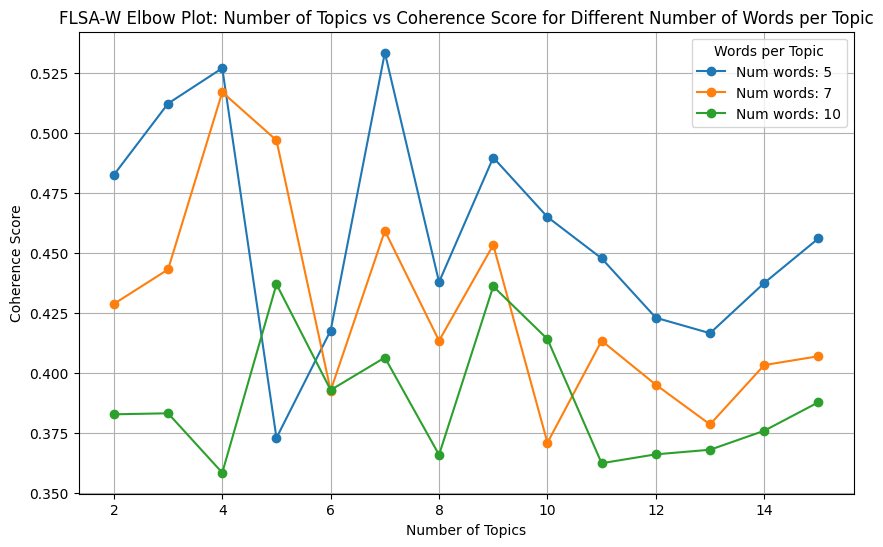

In [25]:
# Plot the elbow curve
plot_elbow_curve(results)

## Train Topic Models

In [25]:
# the optimal number of topics according to FLSA-W
NUMBER_OF_TOPICS = 5

# Dataset has low lexical richness, so we use a smaller number of words per topic
NUMBER_OF_WORDS_PER_TOPIC = 5

In [26]:
def train_topic_model(train_data, model_type='LDA', num_topics=NUMBER_OF_TOPICS, num_words_per_topic=NUMBER_OF_WORDS_PER_TOPIC,
                      preprocess=False, top_percent=0, bottom_percent=0, words_to_exclude=None, use_bigrams=False, remove_single_character=False):
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: dict, the text to train the model on with key 'preprocessed_content'
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - num_topics: int, the number of topics to use for the model
    - num_words_per_topic: int, the number of words per topic to use for the model
    - preprocess: bool, whether to preprocess the data using remove_top_bottom_words
    - top_percent: int, the top n% of words to remove based on frequency
    - bottom_percent: int, the bottom n% of words to remove based on frequency
    - words_to_exclude: list of str, specific words to exclude from the data
    - use_bigrams: bool, whether to include bigrams in the data
    - remove_single_character: bool, whether single characters have to be removed from the token list.

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    - bigrams: the bigrams created (if any)
    """
    # Set seed for reproducible results
    np.random.seed(42)

    train_data_list_tokens = train_data['preprocessed_content']
    bigrams = None

    if remove_single_character:
        train_data_list_tokens = [[token for token in doc if len(token) > 1] for doc in train_data['preprocessed_content']]

    if preprocess:
        train_data_list_tokens = remove_top_bottom_words(
            train_data_list_tokens,
            top_percent=top_percent,
            bottom_percent=bottom_percent,
            words_to_exclude=words_to_exclude
        )

    if use_bigrams:
        # Detect bigrams in the tokenized text data
        bigram = Phrases(train_data_list_tokens,
                         min_count=5, # min number of times a bigram must appear in the corpus to be considered a phrase
                         threshold=90) # scoring threshold for forming phrases based on the likelihood of the words appearing together versus separately.
        train_data_list_tokens = [bigram[doc] for doc in train_data_list_tokens]
        bigrams = bigram

    # Filter out empty lists
    train_data_list_tokens = [tokens for tokens in train_data_list_tokens if tokens]
    train_data_list_string = [' '.join(tokens) for tokens in train_data_list_tokens]

    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)

        # Remove very common and very rare words from dictionary
        dictionary.filter_extremes(no_below=0.5, no_above=0.5)

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=5,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=num_words_per_topic)

        return lda_model, topics, bigrams, train_data_list_tokens, dictionary

    elif model_type == 'FLSA-W':
        flsa_w_model = FLSA_W(
            input_file=train_data_list_tokens,
            num_topics=num_topics,
            num_words=num_words_per_topic
        )
        pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model
        topics = flsa_w_model.show_topics(representation='words')

        return flsa_w_model, topics, bigrams, train_data_list_tokens, None

    elif model_type == 'BERTopic':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)

        # Train BERTopic model
        topic_model = BERTopic(nr_topics = num_topics + 1, top_n_words = num_words_per_topic) # num_topics + 1 to disregard the noise (-1) topic
        _, _ = topic_model.fit_transform(train_data_list_string)

        topics = topic_model.get_topics()

        return topic_model, topics, bigrams, train_data_list_tokens, dictionary

    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

## Iteration 1

### LDA

In [33]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v1, model_type='LDA')

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.009*"revenues" + 0.009*"rank" + 0.009*"million" + 0.007*"consensus" + 0.007*"estimate" + 0.006*"share" + 0.006*"per" + 0.005*"our" + 0.004*"fiscal" + 0.004*"8"
Topic 2: 0.010*"u" + 0.009*"percent" + 0.009*"china" + 0.007*"semiconductor" + 0.006*"said" + 0.006*"trade" + 0.006*"etf" + 0.006*"fund" + 0.005*"index" + 0.005*"0"
Topic 3: 0.008*"intel" + 0.008*"amd" + 0.005*"driving" + 0.004*"data" + 0.004*"ai" + 0.004*"gaming" + 0.003*"said" + 0.003*"chips" + 0.003*"revenue" + 0.003*"self"
Topic 4: 0.010*"i" + 0.006*"week" + 0.005*"t" + 0.005*"out" + 0.005*"some" + 0.004*"investors" + 0.004*"if" + 0.004*"one" + 0.004*"there" + 0.004*"their"
Topic 5: 0.018*"0" + 0.008*"trade" + 0.008*"inc" + 0.007*"u" + 0.007*"oil" + 0.006*"were" + 0.006*"traded" + 0.006*"rose" + 0.006*"fell" + 0.005*"down"

Vocabulary size: 36,247

Coherence Score: 0.5258


### FLSA-W

In [34]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams, train_data_list_tokens, _ = train_topic_model(train_data_v1,
                                                         model_type='FLSA-W')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0004*"gmt" + 0.0003*"rises" + 0.0003*"the" + 0.0003*"to" + 0.0003*"in"')
(1, '0.0017*"nvda" + 0.0017*"nvidia" + 0.0015*"com" + 0.0015*"2017" + 0.0015*"nasdaq"')
(2, '0.0007*"reuters" + 0.0006*"traded" + 0.0006*"exchange" + 0.0006*"chipmaker" + 0.0005*"previously"')
(3, '0.0083*"book" + 0.0073*"evolution" + 0.0071*"books" + 0.0066*"richard" + 0.0063*"science"')
(4, '0.0002*"the" + 0.0002*"to" + 0.0002*"in" + 0.0002*"of" + 0.0002*"a"')


FLSA-W Topics:

Topic 1: gmt, rises, the, to, in
Topic 2: nvda, nvidia, com, 2017, nasdaq
Topic 3: reuters, traded, exchange, chipmaker, previously
Topic 4: book, evolution, books, richard, science
Topic 5: the, to, in, of, a

Vocabulary size: 36,322

Coherence Score: 0.5883
Diversity Score: 0.88
Interpretability Score: 0.5177


### BERTopic

In [35]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v1, model_type='BERTopic')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_list_tokens, dictionary)

No bigrams were created.
BERTopic Topic Info:

   Topic  Count                    Name                 Representation  \
0     -1    970        -1_the_of_to_and         [the, of, to, and, in]   
1      0   2057         0_the_to_and_of         [the, to, and, of, in]   
2      1    166    1_the_to_driving_and    [the, to, driving, and, in]   
3      2    148  2_traded_nvidia_at_the  [traded, nvidia, at, the, on]   
4      3     34   3_facebook_the_to_and   [facebook, the, to, and, in]   
5      4     25   4_the_to_qualcomm_and   [the, to, qualcomm, and, in]   

                                 Representative_Docs  
0  [semiconductor industry outlook april 2017 the...  
1  [technology stock roundup aapl googl amzn fb w...  
2  [can intel challenge nvidia in the self drivin...  
3  [nvidia rises 4 investing com nvidia nasdaq nv...  
4  [facebook fb launches tools to prevent misuse ...  
5  [tech stock roundup aapl tax bill googl nest t...  

BERTopic Topics with Word Probabilities:

Topic 

## Iteration 2

### LDA

In [36]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2,
    model_type='LDA',
    preprocess=True,
    top_percent=2,
    bottom_percent=2,
    words_to_exclude={'inc'}
    )

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.004*"herein" + 0.003*"engage" + 0.003*"highlights" + 0.003*"material" + 0.003*"profitable" + 0.003*"whole" + 0.003*"subject" + 0.003*"actual" + 0.003*"zero" + 0.002*"podcast"
Topic 2: 0.002*"uber" + 0.002*"dma" + 0.002*"vix" + 0.002*"baidu" + 0.002*"mobileye" + 0.002*"n" + 0.001*"auto" + 0.001*"jobs" + 0.001*"say" + 0.001*"work"
Topic 3: 0.004*"cards" + 0.003*"sma" + 0.003*"radeon" + 0.003*"datacenter" + 0.003*"processor" + 0.003*"geforce" + 0.002*"ryzen" + 0.002*"gamers" + 0.002*"streaming" + 0.002*"crypto"
Topic 4: 0.004*"gmt" + 0.003*"lowest" + 0.003*"et" + 0.002*"seven" + 0.002*"usd" + 0.002*"traders" + 0.002*"yields" + 0.002*"talks" + 0.002*"central" + 0.002*"meeting"
Topic 5: 0.002*"acquisitions" + 0.002*"outperforming" + 0.002*"netapp" + 0.002*"western" + 0.002*"trailing" + 0.002*"sporting" + 0.002*"prospects" + 0.002*"pure" + 0.002*"mellanox" + 0.002*"robotics"

Vocabulary size: 30,853

Coherence Score: 

### FLSA-W

In [37]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams, train_data_list_tokens, _ = train_topic_model(train_data_v2,
                                                model_type='FLSA-W',
                                                preprocess=True,
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus'})

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0099*"book" + 0.0094*"evolution" + 0.0083*"books" + 0.008*"richard" + 0.0073*"certainty"')
(1, '0.0002*"premarket" + 0.0002*"rises" + 0.0002*"" + 0.0002*"troy" + 0.0002*"nasdaq"')
(2, '0.002*"technological" + 0.002*"episode" + 0.0019*"becoming" + 0.0018*"world" + 0.0017*"new"')
(3, '0.0004*"uncover" + 0.0004*"esp" + 0.0004*"ounce" + 0.0004*"falls" + 0.0003*"unchanged"')
(4, '0.0012*"corporation" + 0.0011*"gained" + 0.0011*"investing" + 0.0011*"corp" + 0.001*"broader"')


FLSA-W Topics:

Topic 1: book, evolution, books, richard, certainty
Topic 2: premarket, rises, , troy, nasdaq
Topic 3: technological, episode, becoming, world, new
Topic 4: uncover, esp, ounce, falls, unchanged
Topic 5: corporation, gained, investing, corp, broader

Vocabulary size: 32,132

Coherence Score: 0.5277
Diversity Score: 1.0
Interpretability Score: 0.5277


### BERTopic

In [38]:
# Train BERTopic model on the second version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v2, model_type='BERTopic')

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_list_tokens, dictionary)

No bigrams were created.
BERTopic Topic Info:

   Topic  Count                             Name  \
0     -1   1050     -1_year_nasdaq_zacks_company   
1      0   2131      0_nasdaq_year_zacks_company   
2      1    131        1_traded_seven_lowest_gmt   
3      2     52        2_gaming_games_game_video   
4      3     21    3_qualcomm_commission_eu_said   
5      4     15  4_markets_italy_rallied_climbed   

                                Representation  \
0       [year, nasdaq, zacks, company, stocks]   
1     [nasdaq, year, zacks, company, earnings]   
2        [traded, seven, lowest, gmt, highest]   
3         [gaming, games, game, video, nasdaq]   
4  [qualcomm, commission, eu, said, antitrust]   
5   [markets, italy, rallied, climbed, soared]   

                                 Representative_Docs  
0  [electro scientific advanced drainage systems ...  
1  [zacks analyst blog highlights apple applied m...  
2  [falls  investing com nasdaq fell   trade     ...  
3  [ea latest buy

## Iteration 3

### LDA

In [39]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v3,
    model_type='LDA',
    preprocess=True,
    words_to_exclude={'inc','et'},
    top_percent=2,
    bottom_percent=2
    )

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.004*"barrel" + 0.004*"usd" + 0.004*"sma" + 0.003*"blockchain" + 0.003*"worst" + 0.003*"scenario" + 0.003*"mellanox" + 0.003*"gmt" + 0.003*"treasury" + 0.003*"central"
Topic 2: 0.004*"advice" + 0.004*"herein" + 0.003*"engage" + 0.003*"profitable" + 0.003*"actual" + 0.003*"legal" + 0.003*"whole" + 0.003*"seven" + 0.003*"subject" + 0.002*"zero"
Topic 3: 0.002*"mining" + 0.002*"possible" + 0.002*"source" + 0.002*"question" + 0.002*"february" + 0.001*"getting" + 0.001*"got" + 0.001*"really" + 0.001*"break" + 0.001*"probably"
Topic 4: 0.003*"approximately" + 0.003*"delivered" + 0.003*"primarily" + 0.003*"outperforming" + 0.003*"netapp" + 0.003*"infrastructure" + 0.003*"charge" + 0.003*"broadcom" + 0.003*"returned" + 0.003*"pure"
Topic 5: 0.003*"radeon" + 0.003*"baidu" + 0.002*"cadence" + 0.002*"server" + 0.002*"geforce" + 0.002*"dma" + 0.002*"experience" + 0.002*"ryzen" + 0.002*"cpu" + 0.002*"supplier"

Vocabulary siz

### FLSA-W

In [40]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams, train_data_list_tokens, _ = train_topic_model(train_data_v3,
                                                model_type='FLSA-W',
                                                preprocess=True,
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus', 'googl', 'amat', 'et'})

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

No bigrams were created.


FLSA-W Topics with Word Probabilities:

(0, '0.0014*"corporation" + 0.0012*"investing" + 0.0012*"gained" + 0.0012*"intc" + 0.0012*"broader"')
(1, '0.0124*"book" + 0.0104*"evolution" + 0.0087*"richard" + 0.0079*"certainty" + 0.0068*"professor"')
(2, '0.002*"technological" + 0.002*"becoming" + 0.0018*"channel" + 0.0018*"belief" + 0.0017*"biology"')
(3, '0.0004*"uncover" + 0.0004*"performer" + 0.0004*"esp" + 0.0004*"ounce" + 0.0004*"traded"')
(4, '0.0003*"premarket" + 0.0002*"troy" + 0.0002*"company" + 0.0002*"nasdaq" + 0.0002*"market"')


FLSA-W Topics:

Topic 1: corporation, investing, gained, intc, broader
Topic 2: book, evolution, richard, certainty, professor
Topic 3: technological, becoming, channel, belief, biology
Topic 4: uncover, performer, esp, ounce, traded
Topic 5: premarket, troy, company, nasdaq, market

Vocabulary size: 29,048

Coherence Score: 0.4693
Diversity Score: 1.0
Interpretability Score: 0.4693


### BERTopic

In [26]:
# Train BERTopic model on the second version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v2,
                                                                                                 model_type='BERTopic',
                                                                                                 preprocess=True,
                                                                                                 top_percent=1,
                                                                                                 bottom_percent=1)

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_list_tokens, dictionary)

No bigrams were created.
BERTopic Topic Info:

   Topic  Count                                Name  \
0     -1   1223         -1_number_esp_micro_leading   
1      0   1976          0_vehicles_etfs_car_closed   
2      1    146          1_seven_lowest_gmt_highest   
3      2     28   2_eu_commission_antitrust_patents   
4      3     14      3_italy_rallied_soared_climbed   
5      4     13  4_beats_releasenow_press_dividends   

                                   Representation  \
0            [number, esp, micro, leading, rates]   
1            [vehicles, etfs, car, closed, added]   
2         [seven, lowest, gmt, highest, exchange]   
3  [eu, commission, antitrust, patents, european]   
4   [italy, rallied, soared, climbed, australian]   
5   [beats, releasenow, press, dividends, disney]   

                                 Representative_Docs  
0  [blog highlights stmicroelectronics n v lam ap...  
1  [soft pressure descends overseas inflation wal...  
2  [rises gmt exchange volume 

## Iteration 4

### LDA

Since Version 2 gave the highest coherence, we will do another iteration which adds the bigrams

In [42]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2,
    model_type='LDA',
    preprocess=True,
    top_percent=2,
    bottom_percent=2,
    words_to_exclude={'inc'},
    use_bigrams=True
    )

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

Top 15 most common bigrams and respective frequencies:

1 - balance_sheet                  236
2 - federal_reserve                222
3 - goldman_sachs                  218
4 - et_gmt                         205
5 - alibaba_baba                   198
6 - cisco_csco                     191
7 - boeing_ba                      184
8 - morgan_stanley                 184
9 - lam_lrcx                       157
10- lowest_seven                   154
11- subject_notice                 152
12- guarantee_inherent             151
13- material_informational         151
14- purposes_nothing               151
15- herein_constitutes             151


LDA Topics with Word Probabilities:

Topic 1: 0.002*"dropped" + 0.002*"talks" + 0.002*"n" + 0.002*"meeting" + 0.002*"april" + 0.002*"country" + 0.002*"donald" + 0.002*"et_gmt" + 0.001*"federal_reserve" + 0.001*"huawei"
Topic 2: 0.002*"machine" + 0.002*"dma" + 0.002*"deep" + 0.002*"series" + 0.002*"robotics" + 0.002*"work" + 0.002*"working" + 0.002*"trader

### FLSA-W

In [43]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, bigrams, train_data_list_tokens, _ = train_topic_model(train_data_v3,
                                                model_type='FLSA-W',
                                                preprocess=True,
                                                words_to_exclude={'gmt', 'inc', 'com', 'whileolympusshares', 'upnoteus', 'googl', 'amat', 'et'},
                                                use_bigrams=True)

# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)

Top 15 most common bigrams and respective frequencies:

1 - long_term                      1262
2 - wall_street                    1128
3 - data_center                    1128
4 - self_driving                   1084
5 - non_gaap                       858
6 - artificial_intelligence        804
7 - advanced_micro                 689
8 - bottom_line                    620
9 - trade_war                      569
10- united_state                   567
11- dow_jones                      551
12- applied_material               475
13- interest_rate                  427
14- gross_margin                   420
15- industrial_average             414


FLSA-W Topics with Word Probabilities:

(0, '0.0003*"worst_performer" + 0.0003*"original_post" + 0.0003*"slumped" + 0.0003*"philadelphia_semiconductor" + 0.0003*"sell_rated"')
(1, '0.0018*"corporation" + 0.0017*"rank" + 0.0017*"intc" + 0.0017*"broader" + 0.0016*"nasdaq"')
(2, '0.011*"book" + 0.009*"science" + 0.0088*"evolution" + 0.007*"certainty" + 0

### BERTopic

In [30]:
# Train BERTopic model on the third version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v3,
                                                                                                 model_type='BERTopic',
                                                                                                 preprocess=True,
                                                                                                 top_percent=1,
                                                                                                 bottom_percent=1)
# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_list_tokens, dictionary)

No bigrams were created.
BERTopic Topic Info:

   Topic  Count                                  Name  \
0     -1   1405                    -1_tax_pc_esp_part   
1      0   1441  0_bitcoin_qualcomm_option_volatility   
2      1    377       1_storage_gpus_tesla_automotive   
3      2    149            2_seven_lowest_gmt_highest   
4      3     14            3_softbank_vision_son_uber   
5      4     14        4_italy_rallied_soared_climbed   

                                    Representation  \
0                       [tax, pc, esp, part, made]   
1  [bitcoin, qualcomm, option, volatility, rising]   
2     [storage, gpus, tesla, automotive, mellanox]   
3          [seven, lowest, gmt, highest, exchange]   
4            [softbank, vision, son, uber, wework]   
5    [italy, rallied, soared, climbed, australian]   

                                 Representative_Docs  
0  [roundup msft tsla packed event msft gtc parti...  
1  [virus flare taking weigh open running route t...  
2  [miss 

## Iteration 5

### LDA

The change from V2 to V3 is the removal of single characters and lemmatization. In this iteration, the single characters are deleted from version 2, since by ituition it would not make sense to include these.

In [45]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2,
    model_type='LDA',
    preprocess=True,
    top_percent=2,
    bottom_percent=2,
    words_to_exclude={'inc'},
    remove_single_character=True
    )

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.003*"herein" + 0.003*"engage" + 0.002*"subject" + 0.002*"featured" + 0.002*"whole" + 0.002*"actual" + 0.002*"profitable" + 0.002*"material" + 0.002*"particular" + 0.002*"transaction"
Topic 2: 0.002*"cards" + 0.002*"samsung" + 0.002*"baidu" + 0.002*"sma" + 0.002*"executive" + 0.002*"electronics" + 0.002*"launched" + 0.002*"driver" + 0.002*"develop" + 0.002*"working"
Topic 3: 0.003*"outperforming" + 0.003*"mellanox" + 0.003*"netapp" + 0.003*"acquisitions" + 0.003*"pure" + 0.003*"seven" + 0.003*"balance" + 0.003*"lowest" + 0.003*"combination" + 0.003*"trailing"
Topic 4: 0.003*"et" + 0.002*"vix" + 0.002*"dma" + 0.002*"yields" + 0.002*"usd" + 0.002*"meeting" + 0.002*"central" + 0.002*"treasury" + 0.002*"federal" + 0.002*"weekly"
Topic 5: 0.003*"trader" + 0.003*"podcast" + 0.003*"kevin" + 0.002*"episode" + 0.002*"tracey" + 0.002*"robotics" + 0.002*"always" + 0.002*"article" + 0.002*"really" + 0.002*"ideas"

Vocabulary

## Best LDA, FLSA-W and BERTopic Model

### LDA

The fourth iteration has been chosen as the final LDA model. This is with version 2 of the preprocessing dataset, but the single characters  are still deleted since this did not align with the intuition of topic modeling. Moreover, this only changed the final score with -0.1 coherence.

In [48]:
LDA_model, LDA_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(
    train_data_v2,
    model_type='LDA',
    preprocess=True,
    top_percent=2,
    bottom_percent=2,
    words_to_exclude={'inc'},
    remove_single_character=True
    )

print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Call the modified evaluation function
lda_print_evaluation_metrics(LDA_model, train_data_list_tokens, dictionary)

No bigrams were created.


LDA Topics with Word Probabilities:

Topic 1: 0.003*"herein" + 0.003*"engage" + 0.002*"subject" + 0.002*"featured" + 0.002*"whole" + 0.002*"actual" + 0.002*"profitable" + 0.002*"material" + 0.002*"particular" + 0.002*"transaction"
Topic 2: 0.002*"cards" + 0.002*"samsung" + 0.002*"baidu" + 0.002*"sma" + 0.002*"executive" + 0.002*"electronics" + 0.002*"launched" + 0.002*"driver" + 0.002*"develop" + 0.002*"working"
Topic 3: 0.003*"outperforming" + 0.003*"mellanox" + 0.003*"netapp" + 0.003*"acquisitions" + 0.003*"pure" + 0.003*"seven" + 0.003*"balance" + 0.003*"lowest" + 0.003*"combination" + 0.003*"trailing"
Topic 4: 0.003*"et" + 0.002*"vix" + 0.002*"dma" + 0.002*"yields" + 0.002*"usd" + 0.002*"meeting" + 0.002*"central" + 0.002*"treasury" + 0.002*"federal" + 0.002*"weekly"
Topic 5: 0.003*"trader" + 0.003*"podcast" + 0.003*"kevin" + 0.002*"episode" + 0.002*"tracey" + 0.002*"robotics" + 0.002*"always" + 0.002*"article" + 0.002*"really" + 0.002*"ideas"

Vocabulary

Topic 0: {'herein': 3.0, 'engage': 3.0, 'subject': 2.0, 'featured': 2.0, 'whole': 2.0, 'actual': 2.0, 'profitable': 2.0, 'material': 2.0, 'particular': 2.0, 'transaction': 2.0}


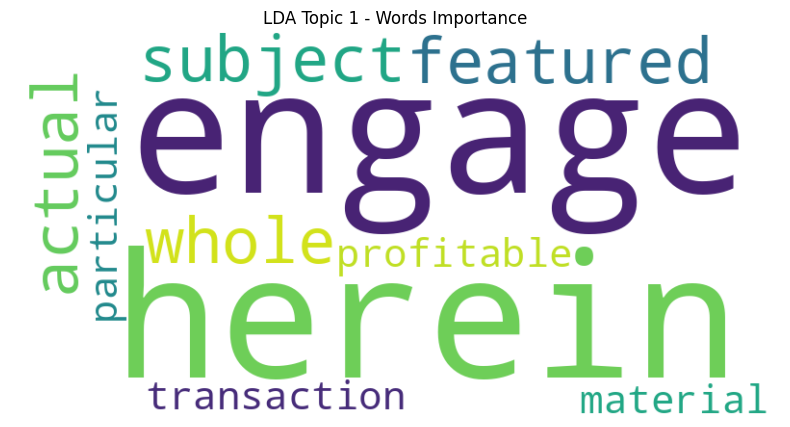

Topic 1: {'cards': 2.0, 'samsung': 2.0, 'baidu': 2.0, 'sma': 2.0, 'executive': 2.0, 'electronics': 2.0, 'launched': 2.0, 'driver': 2.0, 'develop': 2.0, 'working': 2.0}


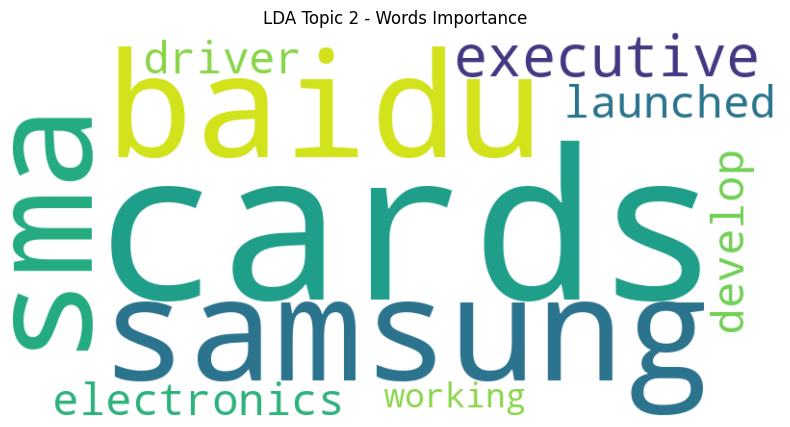

Topic 2: {'outperforming': 3.0, 'mellanox': 3.0, 'netapp': 3.0, 'acquisitions': 3.0, 'pure': 3.0, 'seven': 3.0, 'balance': 3.0, 'lowest': 3.0, 'combination': 3.0, 'trailing': 3.0}


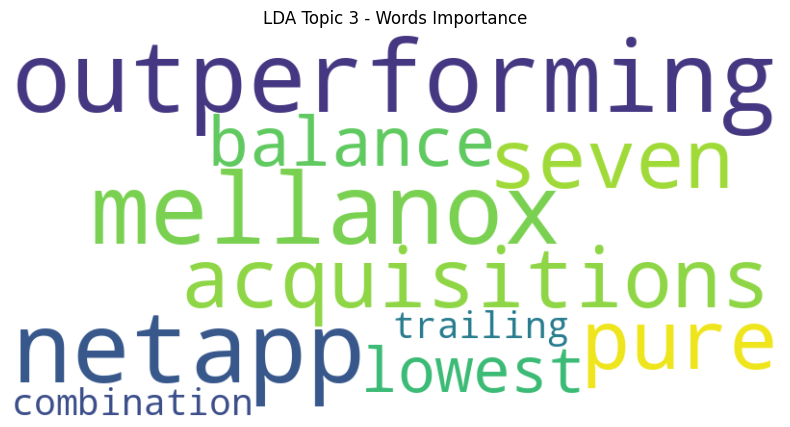

Topic 3: {'et': 3.0, 'vix': 2.0, 'dma': 2.0, 'yields': 2.0, 'usd': 2.0, 'meeting': 2.0, 'central': 2.0, 'treasury': 2.0, 'federal': 2.0, 'weekly': 2.0}


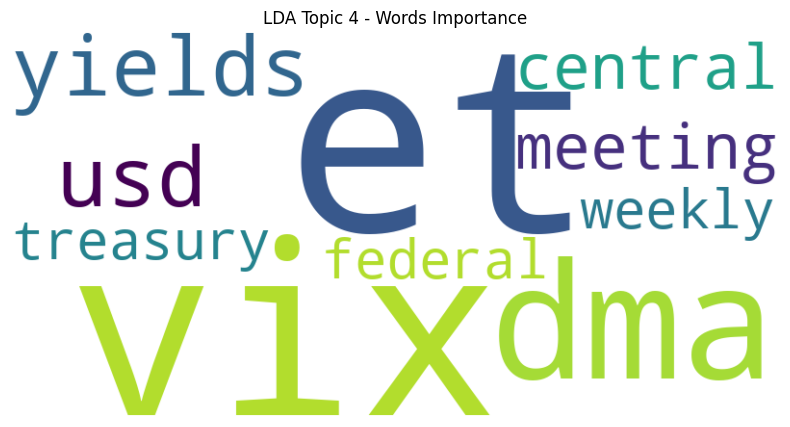

Topic 4: {'trader': 3.0, 'podcast': 3.0, 'kevin': 3.0, 'episode': 2.0, 'tracey': 2.0, 'robotics': 2.0, 'always': 2.0, 'article': 2.0, 'really': 2.0, 'ideas': 2.0}


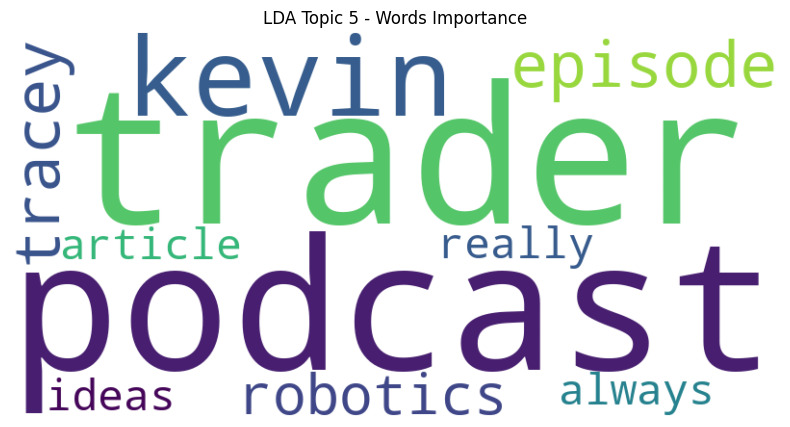

In [49]:
# Get the topics from the model
topic_tuples = LDA_model.show_topics()

# Plot Topic-Words Importance
plot_topic_words_importance(topic_tuples, 'LDA')

### FLSA-W

In [50]:
# Print evaluation metrics for the FLSA-W model
flsa_w_print_evaluation_metrics(flsa_w_model, flsa_w_topics)



FLSA-W Topics with Word Probabilities:

(0, '0.0003*"worst_performer" + 0.0003*"original_post" + 0.0003*"slumped" + 0.0003*"philadelphia_semiconductor" + 0.0003*"sell_rated"')
(1, '0.0018*"corporation" + 0.0017*"rank" + 0.0017*"intc" + 0.0017*"broader" + 0.0016*"nasdaq"')
(2, '0.011*"book" + 0.009*"science" + 0.0088*"evolution" + 0.007*"certainty" + 0.0069*"modern"')
(3, '0.0004*"past_seven" + 0.0004*"traded_highest" + 0.0004*"lowest_during" + 0.0004*"start_session" + 0.0004*"exchange_volume"')
(4, '0.0008*"traded" + 0.0008*"composite" + 0.0007*"reuters" + 0.0007*"previously" + 0.0007*"president_donald"')


FLSA-W Topics:

Topic 1: worst_performer, original_post, slumped, philadelphia_semiconductor, sell_rated
Topic 2: corporation, rank, intc, broader, nasdaq
Topic 3: book, science, evolution, certainty, modern
Topic 4: past_seven, traded_highest, lowest_during, start_session, exchange_volume
Topic 5: traded, composite, reuters, previously, president_donald

Vocabulary size: 31,576



Topic 0: {'worst_performer': 0.3, 'original_post': 0.3, 'slumped': 0.3, 'philadelphia_semiconductor': 0.3, 'sell_rated': 0.3}


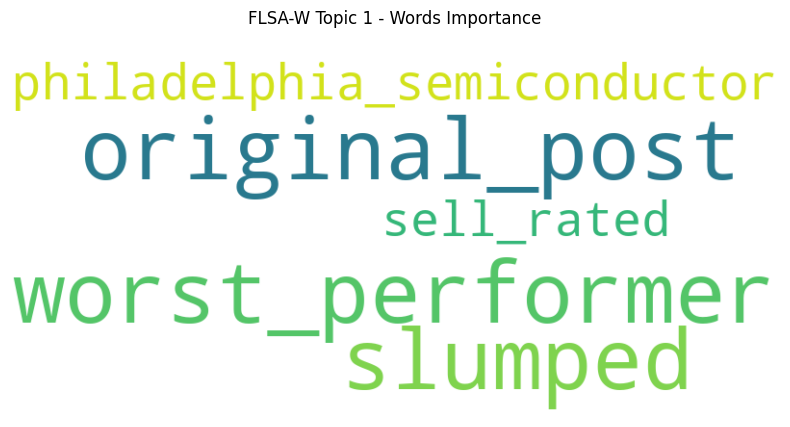

Topic 1: {'corporation': 1.8, 'rank': 1.7, 'intc': 1.7, 'broader': 1.7, 'nasdaq': 1.6}


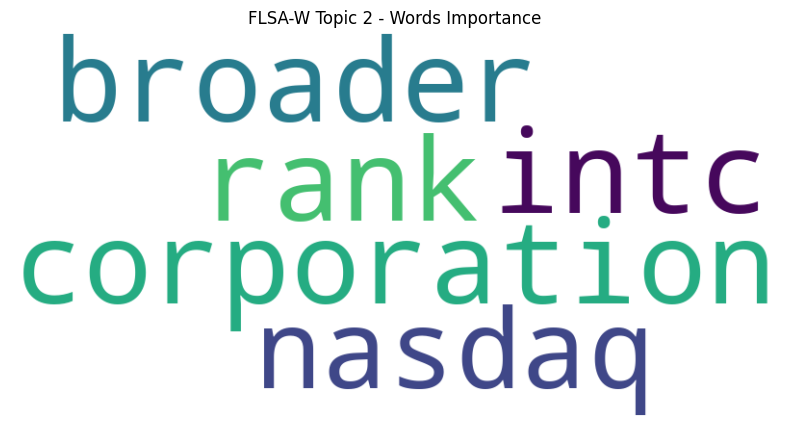

Topic 2: {'book': 11.0, 'science': 9.0, 'evolution': 8.8, 'certainty': 7.0, 'modern': 6.8999999999999995}


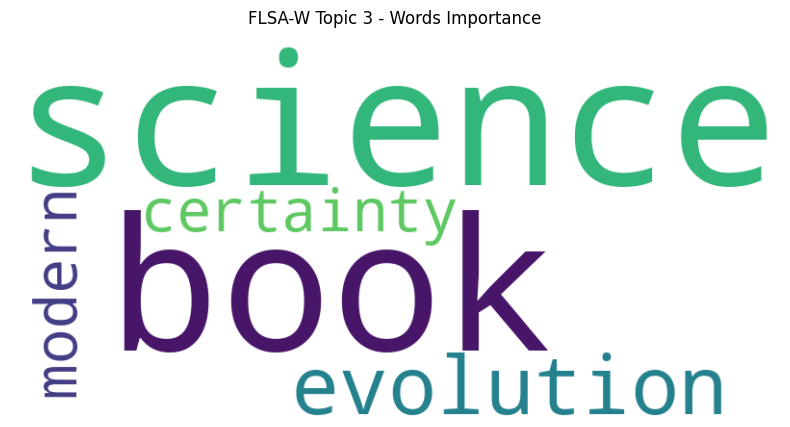

Topic 3: {'past_seven': 0.4, 'traded_highest': 0.4, 'lowest_during': 0.4, 'start_session': 0.4, 'exchange_volume': 0.4}


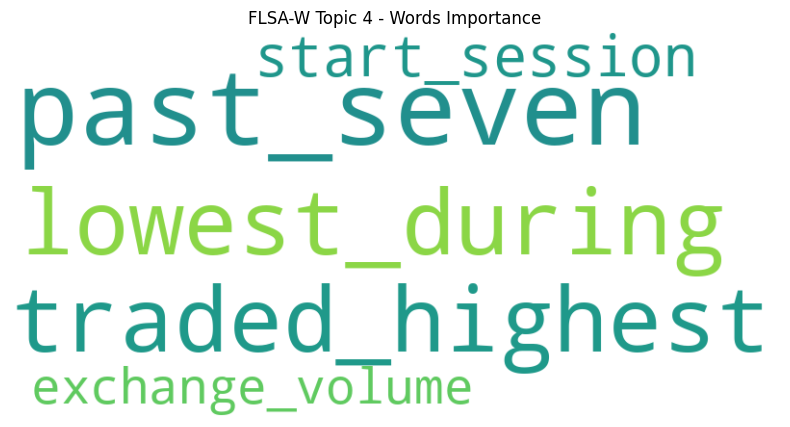

Topic 4: {'traded': 0.8, 'composite': 0.8, 'reuters': 0.7, 'previously': 0.7, 'president_donald': 0.7}


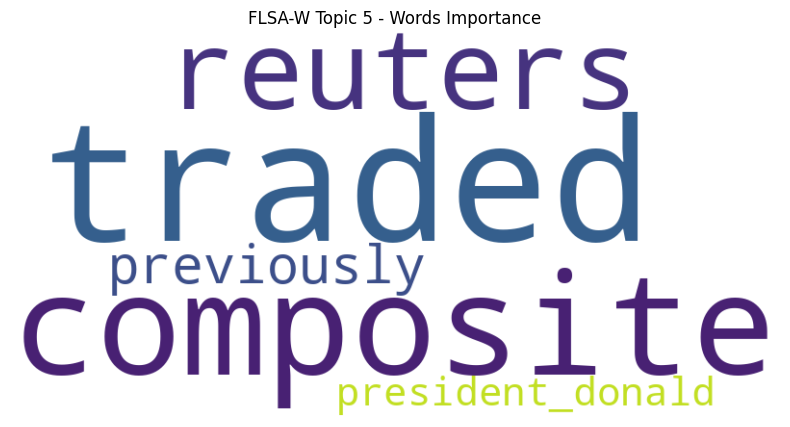

In [51]:
# Get the topics from the model
topic_tuples = flsa_w_model.show_topics()

# Plot Topic-Words Importance
plot_topic_words_importance(topic_tuples, 'FLSA-W')

### BERTopic

Since iteration 4 had the highest coherence score, this was chosen as the final BERTopic model.

In [27]:
# Train BERTopic model on the third version of the preprocessed dataset
bertopic_model, bertopic_topics, bigrams, train_data_list_tokens, dictionary = train_topic_model(train_data_v3,
                                                                                                 model_type='BERTopic',
                                                                                                 preprocess=True,
                                                                                                 top_percent=1,
                                                                                                 bottom_percent=1)
# Print the most common bigrams
print_most_common_bigrams(bigrams, train_data_list_tokens, top_n=15)

# Evaluation metrics of the BERTopic model
bertopic_print_evaluation_metrics(bertopic_model, bertopic_topics, train_data_list_tokens, dictionary)

No bigrams were created.
BERTopic Topic Info:

   Topic  Count                                 Name  \
0     -1   1332               -1_tax_pc_part_forward   
1      0   1841        0_bitcoin_tesla_option_rising   
2      1    149           1_seven_lowest_gmt_highest   
3      2     50  2_huawei_qualcomm_patent_commission   
4      3     14           3_softbank_vision_son_uber   
5      4     14       4_italy_rallied_soared_climbed   

                                      Representation  \
0                   [tax, pc, part, forward, change]   
1             [bitcoin, tesla, option, rising, gpus]   
2            [seven, lowest, gmt, highest, exchange]   
3  [huawei, qualcomm, patent, commission, governm...   
4              [softbank, vision, son, uber, wework]   
5      [italy, rallied, soared, climbed, australian]   

                                 Representative_Docs  
0  [weighing ready holiday shopping normal emphas...  
1  [post bullish respective moving dmas respectiv...  
2 

## Final Topic Model (BERTopic)

Topic Similarity Matrix

In [44]:
bertopic_model.visualize_heatmap()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_bitcoin_tesla_option, 1_seven_lowest_gmt,
                    2_huawei_qualcomm_patent, 3_softbank_vision_son,
                    4_italy_rallied_soared],
              'xaxis': 'x',
              'y': [0_bitcoin_tesla_option, 1_seven_lowest_gmt,
                    2_huawei_qualcomm_patent, 3_softbank_vision_son,
                    4_italy_rallied_soared],
              'yaxis': 'y',
              'z': array([[1.        , 0.20541976, 0.72812174, 0.70156325, 0.55084661],
                          [0.20541976, 1.        , 0.04913969, 0.12772981, 0.1502321 ],
                          [0.72812174, 0.04913969, 1.        , 0.56936978, 0.42465588],
                          [0.70156325, 0.12772981, 0.56936978, 1.        , 0.39775212],
                          [0.55084661, 0.1502321 , 0.42465588, 0.39775212, 1.        ]])}],
    'layout': {'coloraxis': {'colorbar': {'title': {'text': 'Similarity Score'}},
                             'colorscale': [[0.0, 'rgb(247,252,240)'], [0.125,
                                            'rgb(224,243,219)'], [0.25,
                                            'rgb(204,235,197)'], [0.375,
                                            'rgb(168,221,181)'], [0.5,
                                            'rgb(123,204,196)'], [0.625,
                                            'rgb(78,179,211)'], [0.75,
                                            'rgb(43,140,190)'], [0.875,
                                            'rgb(8,104,172)'], [1.0,
                                            'rgb(8,64,129)']]},
               'height': 800,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'title': {'text': 'Trend'}},
               'margin': {'t': 60},
               'showlegend': True,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Similarity Matrix</b>',
                         'x': 0.55,
                         'xanchor': 'center',
                         'y': 0.95,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'anchor': 'y', 'constrain': 'domain', 'domain': [0.0, 1.0], 'scaleanchor': 'y'},
               'yaxis': {'anchor': 'x', 'autorange': 'reversed', 'constrain': 'domain', 'domain': [0.0, 1.0]}}
})

Other visualizations

In [29]:
bertopic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'bitcoin | tesla | option | rising | gpus', 1841],
                                   [1, 'seven | lowest | gmt | highest | exchange', 149],
                                   [2, 'huawei | qualcomm | patent | commission | government', 50],
                                   [3, 'softbank | vision | son | uber | wework', 14],
                                   [4, 'italy | rallied | soared | climbed | australian', 14]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([1841,  149,   50,   14,   14], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 1.150625,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([8.422028 , 9.076106 , 7.8004637, 7.7928786, 8.859836 ], dtype=float32),
              'xaxis': 'x',
              'y': array([1.5124502, 1.0588171, 0.8119995, 1.878991 , 2.274322 ], dtype=float32),
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': 6.6239468336105345,
                                'y': 1.6528349563479423,
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': 8.530734407901765,
                                'xshift': 10,
                                'y': 2.6154703378677366}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': 8.530734407901765,
                           'x1': 8.530734407901765,
                           'y0': 0.6901995748281479,
                           'y1': 2.6154703378677366},
                          {'line': {'color': '#9E9E9E', 'width': 2},
                           'type': 'line',
                           'x0': 6.6239468336105345,
                           'x1': 10.437521982192994,
                           'y0': 1.6528349563479423,
                           'y1': 1.6528349563479423}],
               'sliders': [{'active': 0,
                            'pad': {'t': 50},
                            'steps': [{'args': [{'marker.color': [['red', '#B0BEC5', '#B0BEC5', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 0',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', 'red', '#B0BEC5', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 1',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', 'red', '#B0BEC5', '#B0BEC5']]}],
                                       'label': 'Topic 2',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', '#B0BEC5', 'red', '#B0BEC5']]}],
                                       'label': 'Topic 3',
                                       'method': 'update'},
                                      {'args': [{'marker.color': [['#B0BEC5', '#B0BEC5', '#B0BEC5', '#B0BEC5', 'red']]}],
       

In [30]:
bertopic_model.visualize_hierarchy()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.52680265, 0.52680265, 0.        ]),
              'xaxis': 'x',
              'y': array([-15., -15., -25., -25.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.        , 0.92556283, 0.92556283, 0.52680265]),
              'xaxis': 'x',
              'y': array([ -5.,  -5., -20., -20.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(0,116,217)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0., 1., 1., 0.]),
              'xaxis': 'x',
              'y': array([-35., -35., -45., -45.]),
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(0,116,217)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': array([0.92556283, 1.05100711, 1.05100711, 1.        ]),
              'xaxis': 'x',
              'y': array([-12.5, -12.5, -40. , -40. ]),
              'yaxis': 'y'}],
    'layout': {'autosize': False,
               'height': 275,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'hovermode': 'closest',
               'plot_bgcolor': '#ECEFF1',
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Hierarchical Clustering</b>',
                         'x': 0.5,
                         'xanchor': 'center',
                         'yanchor': 'top'},
               'width': 1000,
               'xaxis': {'mirror': 'allticks',
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'ticks': 'outside',
                         'type': 'linear',
                         'zeroline': False},
               'yaxis': {'mirror': 'allticks',
                         'range': [-50.0, 0.0],
                         'rangemode': 'tozero',
                         'showgrid': False,
                         'showline': True,
                         'showticklabels': True,
                         'tickmode': 'array',
                         'ticks': 'outside',
                         'ticktext': [3_softbank_vision_son,
                                      0_bitcoin_tesla_option,
                                      2_huawei_qualcomm_patent,
                                      4_italy_rallied_soared, 1_seven_lowest_gmt],
                         'tickvals': [-5.0, -15.0, -25.0, -35.0, -45.0],
                         'type': 'linear',
                         'zeroline': False}}
})

In [31]:
bertopic_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.007163205549409557, 0.007177136434549939,
                    0.0071784283970072965, 0.0074020457751402926,
                    0.00912631518230011],
              'xaxis': 'x',
              'y': [gpus  , rising  , option  , tesla  , bitcoin  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.6920551873970853, 0.7231177128489876, 0.757578726306175,
                    0.7703359629607865, 0.784454144075592],
              'xaxis': 'x2',
              'y': [exchange  , highest  , gmt  , lowest  , seven  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027599780258764126, 0.02767633941650109,
                    0.03194502678295958, 0.04954284394680782, 0.0724748119595412],
              'xaxis': 'x3',
              'y': [government  , commission  , patent  , qualcomm  , huawei  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.059856810986261215, 0.06789473072297378,
                    0.07482029560760775, 0.16875268001405844, 0.3655612735712082],
              'xaxis': 'x4',
              'y': [wework  , uber  , son  , vision  , softbank  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.1460696519448487, 0.17024779481718763, 0.1744742217617506,
                    0.18227595148784975, 0.20286118825353144],
              'xaxis': 'x5',
              'y': [australian  , climbed  , soared  , rallied  , italy  ],
              'yaxis': 'y5'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 3',
                                'x': 0.9125,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 4',
                                'x': 0.0875,
                  

In [ ]:
bertopic_model.visualize_term_rank()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertext': '<b>Topic -1</b>:tax_pc_part_forward_change',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.00834351, 0.00698525, 0.00691163, 0.00662926, 0.0065985 ])},
             {'hovertext': '<b>Topic 0</b>:bitcoin_tesla_option_rising_gpus',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.00912632, 0.00740205, 0.00717843, 0.00717714, 0.00716321])},
             {'hovertext': '<b>Topic 1</b>:seven_lowest_gmt_highest_exchange',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.78445414, 0.77033596, 0.75757873, 0.72311771, 0.69205519])},
             {'hovertext': '<b>Topic 2</b>:huawei_qualcomm_patent_commission_g',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.07247481, 0.04954284, 0.03194503, 0.02767634, 0.02759978])},
             {'hovertext': '<b>Topic 3</b>:softbank_vision_son_uber_wework',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.36556127, 0.16875268, 0.0748203 , 0.06789473, 0.05985681])},
             {'hovertext': '<b>Topic 4</b>:italy_rallied_soared_climbed_austra',
              'line': {'color': 'black', 'width': 1.5},
              'mode': 'lines+lines',
              'name': '',
              'opacity': 0.1,
              'type': 'scatter',
              'x': array([1, 2, 3, 4, 5]),
              'y': array([0.20286119, 0.18227595, 0.17447422, 0.17024779, 0.14606965])}],
    'layout': {'height': 500,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'showlegend': False,
               'template': '...',
               'title': {'font': {'color': 'Black', 'size': 22},
                         'text': '<b>Term score decline per Topic</b>',
                         'x': 0.5,
                         'xanchor': 'center',
                         'y': 0.9,
                         'yanchor': 'top'},
               'width': 800,
               'xaxis': {'dtick': 2, 'range': [0, 5], 'tick0': 1, 'title': {'text': 'Term Rank'}},
               'yaxis': {'title': {'text': 'c-TF-IDF score'}}}
})